In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import copy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import statsmodels.api as sm

In [421]:
# test_df.csv == not_loop_10000_result
target_df = pd.read_csv("test_df.csv")
target_df

,date,transaction_count,transaction_amount,transaction_flag,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time
0,2017-01-01,0,0.000000e+00,0,NaN,4285.08,NaN,795.150377,4261.48,4485.39,4200.74,284.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,0,0.000000e+00,0,-0.041238,4108.37,0.041238,1199.888264,4285.08,4371.52,3938.77,432.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.944878,97293.875547,0.763861,7.350606,3.176884e+11,2.799811e+08,275190.258573,0.394819,2.526780e+06,997.36,9.816667,2.138666e+06,287576.0,1829.880503,1.839618e+08,290951.0,529709.0,1.573982e+06,6.822471e+06,114872.988609,112.884147,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,2024-09-29,0,0.000000e+00,0,-0.003887,65602.01,0.003887,8337.741110,65858.00,66076.12,65432.00,644.12,16.359363,1413449.0,4132.93780,2.716223e+08,0.000002,5.479800e+08,6342.36127,65432.0,66076.12,65720.242186,65722.977549,0.096502,0.001493,0.001919,-0.003282,-0.004008,6.920803e-08,8.909649e-08,-1.517046e-07,-1.856774e-07,0.083138,0.122141,0.101764,0.078964,0.000018,0.000025,0.000031,0.000023,0.000025,1.641797,604118.606257,NaN,47.124922,8.840440e+13,NaN,NaN,0.721808,6.811640e+08,NaN,10.950000,3.239494e+07,687244.0,4435.012903,1.087474e+09,687427.0,462111.0,4.892956e+05,NaN,496190.298458,7.532710,6508.270968,1008782.0,127.982783
2829,2024-09-30,2,7.738510e+12,1,-0.034670,63327.59,0.034670,30011.087520,65602.01,65618.80,62856.30,2762.50,46.048426,3978584.0,14451.93044,9.243240e+08,0.000004,1.920250e+09,22225.11877,62856.3,65618.80,64033.997243,63984.250377,0.347351,-0.010950,-0.001934,-0.005784,-0.016402,-5.077786e-07,-8.769431e-08,-2.667346e-07,-7.641810e-07,0.429215,0.337447,0.285974,0.336766,0.000063,0.000062,0.000060,0.000054,0.000060,1.637884,604373.114519,NaN,47.050426,8.840440e+13,NaN,NaN,0.791114,6.020611e+08,NaN,11.966667,2.795849e+07,594021.0,4337.401460,1.088162e+09,594224.0,513555.0,9.862190e+05,NaN,470098.750598,7.329882,6701.992701,918173.0,84.141097


In [422]:
target_df = target_df[target_df['date']>='2018-01-01']


target_df = target_df[(target_df['date']>='2019-09-01')&(target_df['date']<='2020-09-01')]

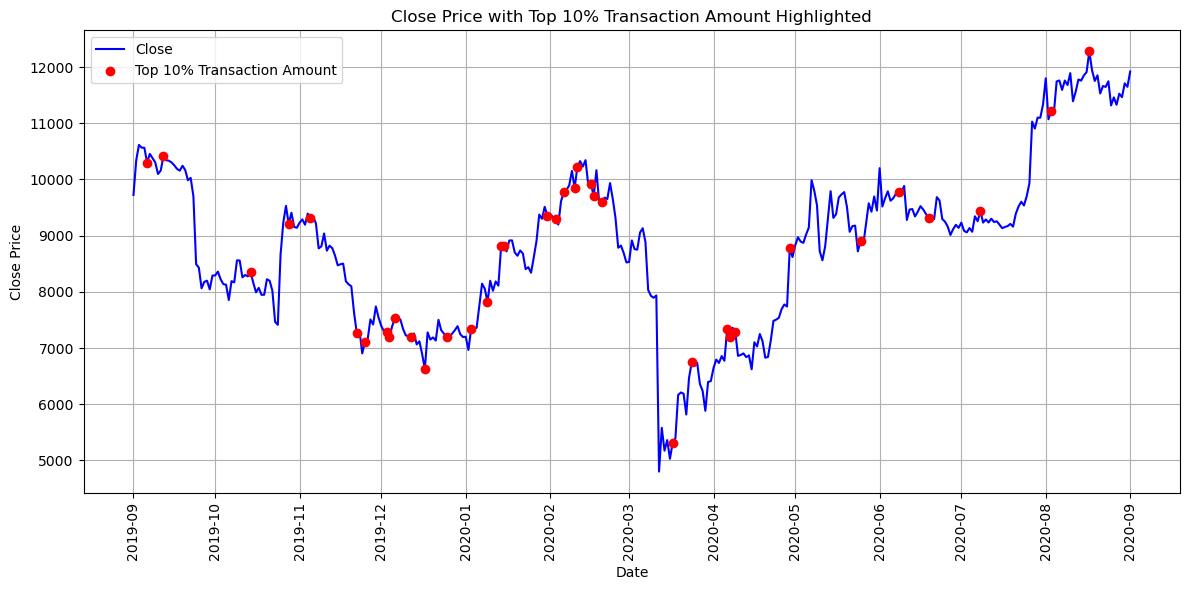

In [423]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 'date' 열을 datetime 형식으로 변환
target_df['date'] = pd.to_datetime(target_df['date'])

# transaction_amount의 상위 10% 기준 계산
threshold = target_df['transaction_amount'].quantile(0.90)

# 상위 10% 조건에 맞는 인덱스 필터링
high_transaction_days = target_df[target_df['transaction_amount'] > threshold]

# 전체 close 데이터 그래프
plt.figure(figsize=(12, 6))
plt.plot(target_df['date'], target_df['close'], label='Close', color='blue')  # X축: 'date', Y축: 'close'

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기
plt.scatter(high_transaction_days['date'], high_transaction_days['close'], color='red', label='Top 10% Transaction Amount', zorder=5)  # X축: 'date', Y축: 'close'

# 날짜 축 포맷 설정 (1달 간격)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1달 간격으로 표시
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식으로 표시

# 그래프 꾸미기
plt.title('Close Price with Top 10% Transaction Amount Highlighted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=90)  # X축 라벨 회전
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [405]:
target_df['target'] = target_df['transaction_flag']

test_target_df_1 = copy.deepcopy(target_df[['date', 'transaction_amount']])
test_target_df_2 = copy.deepcopy(target_df[['date', 'transaction_count']])
test_target_df_3 = copy.deepcopy(target_df[['date', 'transaction_flag']])

test_target_df_1 = test_target_df_1.set_index('date')
test_target_df_2 = test_target_df_2.set_index('date')
test_target_df_3 = test_target_df_3.set_index('date')

target_df = target_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag'], axis=1)

C:\Users\slaye\AppData\Local\Temp\ipykernel_28408\3335901868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['target'] = target_df['transaction_flag']


In [406]:
target_df.set_index('date', inplace=True)
target_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.024523,13380.00,0.024523,8609.915844,13716.36,13818.55,12750.00,1068.55,1.271124,98821.0,3699.634259,4.931474e+07,0.000948,1.077702e+08,1386.237160,12750.00,13818.55,13364.212983,13332.010686,0.103979,-0.010975,0.012634,0.017765,-0.014662,-3.393855e-07,9.075408e-07,1.101233e-06,-4.732937e-07,0.091872,0.116106,0.091282,0.115332,0.000684,0.000740,0.000551,0.000721,0.000680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-01-02,0.096794,14675.11,0.096794,20078.092111,13382.16,15473.49,12890.02,2583.47,2.060408,176954.0,11289.353955,1.573041e+08,0.000935,2.783978e+08,3241.594264,12890.02,15473.49,13811.039480,13933.086632,0.232657,0.032595,0.021497,0.062829,-0.029981,1.669951e-06,1.197538e-06,3.238834e-06,-1.129231e-06,0.184262,0.241013,0.320807,0.183597,0.000582,0.000652,0.000910,0.000770,0.000739,1.041368,150273.540487,1.1963,113.842161,1.931136e+12,3.339191e+09,240354.960602,26.475555,1.641554e+07,13374.98,7.983333,3.994676e+07,324425.0,1994.035088,2.880879e+08,340980.0,850802.0,2.536939e+06,6.606965e+08,9.290166e+06,649.164976,4026.590643,688547.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,-0.003887,65602.01,0.003887,8337.741110,65858.00,66076.12,65432.00,644.12,16.359363,1413449.0,4132.937800,2.716223e+08,0.000002,5.479800e+08,6342.361270,65432.00,66076.12,65720.242186,65722.977549,0.096502,0.001493,0.001919,-0.003282,-0.004008,6.920803e-08,8.909649e-08,-1.517046e-07,-1.856774e-07,0.083138,0.122141,0.101764,0.078964,0.000018,0.000025,0.000031,0.000023,0.000025,1.641797,604118.606257,NaN,47.124922,8.840440e+13,NaN,NaN,0.721808,6.811640e+08,NaN,10.950000,3.239494e+07,687244.0,4435.012903,1.087474e+09,687427.0,462111.0,4.892956e+05,NaN,4.961903e+05,7.532710,6508.270968,1008782.0,127.982783,0
2024-09-30,-0.034670,63327.59,0.034670,30011.087520,65602.01,65618.80,62856.30,2762.50,46.048426,3978584.0,14451.930440,9.243240e+08,0.000004,1.920250e+09,22225.118770,62856.30,65618.80,64033.997243,63984.250377,0.347351,-0.010950,-0.001934,-0.005784,-0.016402,-5.077786e-07,-8.769431e-08,-2.667346e-07,-7.641810e-07,0.429215,0.337447,0.285974,0.336766,0.000063,0.000062,0.000060,0.000054,0.000060,1.637884,604373.114519,NaN,47.050426,8.840440e+13,NaN,NaN,0.791114,6.020611e+08,NaN,11.966667,2.795849e+07,594021.0,4337.401460,1.088162e+09,594224.0,513555.0,9.862190e+05,NaN,4.700988e+05,7.329882,6701.992701,918173.0,84.141097,1


In [407]:
# 결측치 처리
target_df = target_df.fillna(target_df.mean())

In [409]:
shifted_columns = target_df.columns.difference(['target'])
shifted_df = target_df[shifted_columns].shift(1)

shifted_columns = shifted_df.columns + '_shifted'
shifted_df.columns = shifted_columns

combined_df = pd.concat([shifted_df], axis=1)
combined_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.024523,1.263132,212.466831,352000.393335,13380.00,84.346074,1.377038,0.012634,0.000740,9.075408e-07,0.116106,-4.732937e-07,0.115332,-3.393855e-07,0.091872,1.101233e-06,0.091282,13364.212983,1386.237160,0.000948,1.271124,0.103979,-0.014662,0.000721,13818.55,12750.00,-0.010975,0.000684,0.017765,0.000551,1.077702e+08,3699.634259,4.931474e+07,98821.0,0.000680,13332.010686,2.897504e+13,137642.922705,1.779227e+09,4.033708,2.100334e+08,13818.55,1068.55,12750.00,21735.929071,9.132760,2.594920e+07,6.700324e+05,4607.731346,325008.502646,320012.586488,2230.526390,6.399782e+08,611845.310006,13716.36,1.728889e+06,-0.024523,3.251735e+08,54.871887,1.432854e+06,8609.915844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.001339,1.775522,75.537497,603889.347914,65858.00,53.782789,1.377038,-0.002505,0.000024,-1.158085e-07,0.106194,1.295088e-07,0.102437,-1.092550e-07,0.109949,1.585881e-07,0.103977,65755.198738,6945.815777,0.000002,15.528970,0.105639,0.002795,0.000023,66260.00,65422.23,-0.002362,0.000022,0.003425,0.000024,6.001185e+08,4501.225340,2.960267e+08,1341703.0,0.000023,65750.063804,8.840440e+13,137642.922705,1.779227e+09,1.298335,5.669043e+08,66260.00,837.77,65422.23,21735.929071,10.116667,2.765172e+07,8.605090e+05,6670.612403,507707.000000,507512.000000,3935.713178,1.086966e+09,477266.000000,65769.95,4.624474e+05,0.001339,3.251735e+08,10.057609,6.675219e+05,9127.233160
2024-09-30,0.003887,1.641797,127.982783,604118.606257,65602.01,47.124922,1.377038,0.001919,0.000025,8.909649e-08,0.122141,-1.856774e-07,0.078964,6.920803e-08,0.083138,-1.517046e-07,0.101764,65720.242186,6342.361270,0.000002,16.359363,0.096502,-0.004008,0.000023,66076.12,65432.00,0.001493,0.000018,-0.003282,0.000031,5.479800e+08,4132.937800,2.716223e+08,1413449.0,0.000025,65722.977549,8.840440e+13,137642.922705

In [388]:
combined_df = combined_df.dropna()
combined_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.024523,1.263132,212.466831,352000.393335,13380.00,84.346074,1.377038,0.012634,0.000740,9.075408e-07,0.116106,-4.732937e-07,0.115332,-3.393855e-07,0.091872,1.101233e-06,0.091282,13364.212983,1386.237160,0.000948,1.271124,0.103979,-0.014662,0.000721,13818.55,12750.00,-0.010975,0.000684,0.017765,0.000551,1.077702e+08,3699.634259,4.931474e+07,98821.0,0.000680,13332.010686,2.897504e+13,137642.922705,1.779227e+09,4.033708,2.100334e+08,13818.55,1068.55,12750.00,21735.929071,9.132760,2.594920e+07,6.700324e+05,4607.731346,325008.502646,320012.586488,2230.526390,6.399782e+08,611845.310006,13716.36,1.728889e+06,-0.024523,3.251735e+08,54.871887,1.432854e+06,8609.915844
2018-01-03,0.096794,1.041368,212.466831,150273.540487,14675.11,113.842161,1.196300,0.021497,0.000652,1.197538e-06,0.241013,-1.129231e-06,0.183597,1.669951e-06,0.184262,3.238834e-06,0.320807,13811.039480,3241.594264,0.000935,2.060408,0.232657,-0.029981,0.000770,15473.49,12890.02,0.032595,0.000582,0.062829,0.000910,2.783978e+08,11289.353955,1.573041e+08,176954.0,0.000739,13933.086632,1.931136e+12,240354.960602,3.339191e+09,26.475555,1.641554e+07,15473.49,2583.47,12890.02,13374.980000,7.983333,3.994676e+07,6.885470e+05,4026.590643,340980.000000,324425.000000,1994.035088,2.880879e+08,850802.000000,13382.16,2.536939e+06,0.096794,6.606965e+08,649.164976,9.290166e+06,20078.092111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.001339,1.775522,75.537497,603889.347914,65858.00,53.782789,1.377038,-0.002505,0.000024,-1.158085e-07,0.106194,1.295088e-07,0.102437,-1.092550e-07,0.109949,1.585881e-07,0.103977,65755.198738,6945.815777,0.000002,15.528970,0.105639,0.002795,0.000023,66260.00,65422.23,-0.002362,0.000022,0.003425,0.000024,6.001185e+08,4501.225340,2.960267e+08,1341703.0,0.000023,65750.063804,8.840440e+13,137642.922705,1.779227e+09,1.298335,5.669043e+08,66260.00,837.77,65422.23,21735.929071,10.116667,2.765172e+07,8.605090e+05,6670.612403,507707.000000,507512.000000,3935.713178,1.086966e+09,477266.000000,65769.95,4.624474e+05,0.001339,3.251735e+08,10.057609,6.675219e+0

In [ ]:
combined_df['target'] = target_df['target']
combined_df

In [390]:
# 스케일링
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)
scaled_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,target
0,0.062062,0.397299,0.008012,0.444484,0.145551,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.440201,0.404278,0.150366,0.056882,0.627574,0.090818,0.039587,0.017100,0.009343,0.0
1,0.245009,0.291361,0.008012,0.000000,0.164089,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.725711,0.145582,0.090307,0.833053,0.189768,0.514102,0.114100,0.024459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,0.003375,0.642072,0.002706,0.999495,0.896731,0.126750,0.225061,0.435870,0.009641,0.453314,0.003349,0.276289,0.006727,0.509903,0.006427,0.612985,0.005286,0.900227,0.032209,0.000290,0.083702,0.004165,0.533420,0.008000,0.893377,0.913298,0.620327,0.009051,0.660659,0.008305,0.033736,0.009786,0.033005,0.087459,0.009159,0.899645,0.952974,0.181199,0.105766,0.008976,0.758783,0.893377,0.059555,0.913298,0.287641,0.321023,0.222963,0.438451,0.575076,0.477419,0.478356,0.662196,0.999365,0.223249,0.895471,0.004495,0.671376,0.090818,0.003805,0.007651,0.010025,0.0
2463,0.009826,0.578190,0.004738,1.000000,0.893067,0.103167,0.225061,0.455895,0.010117,0.473596,0.004493,0.260452,0.003904,0.519486,0.003285,0.595298,0.005100,0.899723,0.029217,0.000321,0.088438,0.003119,0.505362,0.007958,0.890768,0.913441,0.632034,0.006825,0.640373,0.011476,0.030746,0.008801,0.030223,0.092180,0.009950,0.899255,0.952974,0.181199,0.105766,0.004432,0.915511,0.890768,0.045268,0.913441,0.287641,0.35

In [391]:
y = scaled_df['target'].values
X = scaled_df.drop('target', axis=1)

In [392]:
## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [393]:
# shift 1, Linear Regression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('훈련 세트 R2 :', lr.score(X_train, y_train))

# 테스트 셋 예측
lr_y_pred = lr.predict(X_test)

# 정확도
predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': lr_y_pred})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", lr.score(X_test, y_test))

훈련 세트 R2 : 0.1908378138927478
MAE: 0.7328787872921405
MSE: 0.805447487123375
R2: -2.7165624095113556


In [394]:
# XGBR = XGBRegressor(n_estimators=10000, gamma=4.376, subsample=0.70, learning_rate=0.08, max_depth=6, objective='reg:squarederror')
# XGBR.fit(X_train, y_train)

# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", XGBR.score(X_test, y_test))

In [357]:
# 현재 모델
XGBR = XGBRegressor(n_estimators=100000, gamma=0.006, subsample=0.70, learning_rate=0.08, max_depth=3, objective='reg:squarederror')
XGBR.fit(X_train, y_train)

predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

KeyboardInterrupt: 

In [395]:
# 현재 모델
XGBR = XGBRegressor(n_estimators=100000, gamma=0.002, subsample=0.90, learning_rate=0.08, max_depth=3, objective='reg:squarederror')
XGBR.fit(X_train, y_train)

predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

MAE: 0.5214579457945719
MSE: 0.3509230323313113
R2: -0.619258078825583


In [396]:
XGBR.save_model('xgb_model_flag_241226.json')

In [171]:
# 모델 불러오기
XGBR = XGBRegressor()
XGBR.load_model('xgb_model_count.json')

# Error, R2 평가
predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

MAE: 0.013480576860918674
MSE: 0.0003726484641766354
R2: -6.514437497583375


In [397]:
xxx_amount = XGBR.predict(X)
test_X = copy.deepcopy(X)
test_X['ITI_flag'] = xxx_amount
test_X.index = combined_df.index
test_X

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,ITI_flag
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.062062,0.397299,0.008012,0.444484,0.145551,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.440201,0.404278,0.150366,0.056882,0.627574,0.090818,0.039587,0.017100,0.009343,0.007313
2018-01-03,0.245009,0.291361,0.008012,0.000000,0.164089,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.725711,0.145582,0.090307,0.833053,0.189768,0.514102,0.114100,0.024459,0.012771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.003375,0.642072,0.002706,0.999495,0.896731,0.126750,0.225061,0.435870,0.009641,0.453314,0.003349,0.276289,0.006727,0.509903,0.006427,0.612985,0.005286,0.900227,0.032209,0.000290,0.083702,0.004165,0.533420,0.008000,0.893377,0.913298,0.620327,0.009051,0.660659,0.008305,0.033736,0.009786,0.033005,0.087459,0.009159,0.899645,0.952974,0.181199,0.105766,0.008976,0.758783,0.893377,0.059555,0.913298,0.287641,0.321023,0.222963,0.438451,0.575076,0.477419,0.478356,0.662196,0.999365,0.223249,0.895471,0.004495,0.671376,0.090818,0.003805,0.007651,0.010025,0.502126
2024-09-30,0.009826,0.578190,0.004738,1.000000,0.893067,0.103167,0.225061,0.455895,0.010117,0.473596,0.004493,0.260452,0.003904,0.519486,0.003285,0.595298,0.005100,0.899723,0.029217,0.000321,0.088438,0.003119,0.505362,0.007958,0.890768,0.913441,0.632034,0.006825,0.640373,0.011476,0.030746,0.008801,0.03022

In [398]:
test_X[['ITI_flag']].to_csv("ITI_flag_241226.csv", index=True)

In [174]:
test_target_df = copy.deepcopy(target_df)
# test_target_df['ITI'] = test_X['ITI']

test_target_df = test_target_df.fillna(test_target_df.mean())
test_target_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.024523,13380.00,0.024523,8609.915844,13716.36,13818.55,12750.00,1068.55,1.271124,98821.0,3699.634259,4.931474e+07,0.000948,1.077702e+08,1386.237160,12750.00,13818.55,13364.212983,13332.010686,0.103979,-0.010975,0.012634,0.017765,-0.014662,-3.393855e-07,9.075408e-07,1.101233e-06,-4.732937e-07,0.091872,0.116106,0.091282,0.115332,0.000684,0.000740,0.000551,0.000721,0.000680,1.263132,352000.393335,1.377038,84.346074,2.897504e+13,1.779227e+09,137642.922705,4.033708,2.100334e+08,21735.929071,9.132760,2.594920e+07,320012.586488,2230.526390,6.399782e+08,325008.502646,611845.310006,1.728889e+06,3.251735e+08,1.432854e+06,54.871887,4607.731346,6.700324e+05,212.466831,1
2018-01-02,0.096794,14675.11,0.096794,20078.092111,13382.16,15473.49,12890.02,2583.47,2.060408,176954.0,11289.353955,1.573041e+08,0.000935,2.783978e+08,3241.594264,12890.02,15473.49,13811.039480,13933.086632,0.232657,0.032595,0.021497,0.062829,-0.029981,1.669951e-06,1.197538e-06,3.238834e-06,-1.129231e-06,0.184262,0.241013,0.320807,0.183597,0.000582,0.000652,0.000910,0.000770,0.000739,1.041368,150273.540487,1.196300,113.842161,1.931136e+12,3.339191e+09,240354.960602,26.475555,1.641554e+07,13374.980000,7.983333,3.994676e+07,324425.000000,1994.035088,2.880879e+08,340980.000000,850802.000000,2.536939e+06,6.606965e+08,9.290166e+06,649.164976,4026.590643,6.885470e+05,212.466831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,-0.003887,65602.01,0.003887,8337.741110,65858.00,66076.12,65432.00,644.12,16.359363,1413449.0,4132.937800,2.716223e+08,0.000002,5.479800e+08,6342.361270,65432.00,66076.12,65720.242186,65722.977549,0.096502,0.001493,0.001919,-0.003282,-0.004008,6.920803e-08,8.909649e-08,-1.517046e-07,-1.856774e-07,0.083138,0.122141,0.101764,0.078964,0.000018,0.000025,0.000031,0.000023,0.000025,1.641797,604118.606257,1.377038,47.124922,8.840440e+13,1.779227e+09,137642.922705,0.721808,6.811640e+08,21735.929071,10.950000,3.239494e+07,687244.000000,4435.012903,1.087474e+09,687427.000000,462111.000000,4.892956e+05,3.251735e+08,4.961903e+05,7.532710,6508.270968,1.008782e+06,127.982783,0
2024-09-30,-0.034670,63327.59,0.034670,30011.087520,65602.01,65618.80,62856.30,2762.50,46.048426,3978584.0,14451.930440,9.243240e+08,0.000004,1.920250e+09,22225.118770,62856.30,65618.80,64033.997243,63984.250377,0.347351,-0.010950,-0.001934,-0.005784,-0.016402,-5.077786e-07,-8.769431e-08,-2.667346e-07,-7.641810e-07,0.429215,0.337447,0.285974,0.336766,0.000063,0.000062,0.000060,0.000054,0.000060,1.637884,604373.114519,1.377038,47.050426,8.840440e+13,1.

In [175]:
test_target_df_shifted = copy.deepcopy(test_target_df)

shifted_columns = test_target_df.columns.difference(['returns', 'open', 'close', 'target'])

test_shifted_df = test_target_df[shifted_columns]

# test_shifted_df = test_shifted_df[shifted_columns].shift(1)


shifted_columns = test_shifted_df.columns + '_shifted'
test_shifted_df.columns = shifted_columns

test_shifted_df = test_shifted_df.dropna()

test_shifted_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,output-volume_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.024523,1.263132,212.466831,352000.393335,84.346074,1.377038,0.012634,0.000740,9.075408e-07,0.116106,-4.732937e-07,0.115332,-3.393855e-07,0.091872,1.101233e-06,0.091282,13364.212983,1386.237160,0.000948,1.271124,0.103979,-0.014662,0.000721,13818.55,12750.00,-0.010975,0.000684,0.017765,0.000551,1.077702e+08,3699.634259,4.931474e+07,98821.0,0.000680,13332.010686,2.897504e+13,137642.922705,1.779227e+09,4.033708,2.100334e+08,13818.55,1068.55,12750.00,21735.929071,9.132760,2.594920e+07,6.700324e+05,4607.731346,325008.502646,320012.586488,2230.526390,6.399782e+08,611845.310006,1.728889e+06,3.251735e+08,54.871887,1.432854e+06,8609.915844
2018-01-02,0.096794,1.041368,212.466831,150273.540487,113.842161,1.196300,0.021497,0.000652,1.197538e-06,0.241013,-1.129231e-06,0.183597,1.669951e-06,0.184262,3.238834e-06,0.320807,13811.039480,3241.594264,0.000935,2.060408,0.232657,-0.029981,0.000770,15473.49,12890.02,0.032595,0.000582,0.062829,0.000910,2.783978e+08,11289.353955,1.573041e+08,176954.0,0.000739,13933.086632,1.931136e+12,240354.960602,3.339191e+09,26.475555,1.641554e+07,15473.49,2583.47,12890.02,13374.980000,7.983333,3.994676e+07,6.885470e+05,4026.590643,340980.000000,324425.000000,1994.035088,2.880879e+08,850802.000000,2.536939e+06,6.606965e+08,649.164976,9.290166e+06,20078.092111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.003887,1.641797,127.982783,604118.606257,47.124922,1.377038,0.001919,0.000025,8.909649e-08,0.122141,-1.856774e-07,0.078964,6.920803e-08,0.083138,-1.517046e-07,0.101764,65720.242186,6342.361270,0.000002,16.359363,0.096502,-0.004008,0.000023,66076.12,65432.00,0.001493,0.000018,-0.003282,0.000031,5.479800e+08,4132.937800,2.716223e+08,1413449.0,0.000025,65722.977549,8.840440e+13,137642.922705,1.779227e+09,0.721808,6.811640e+08,66076.12,644.12,65432.00,21735.929071,10.950000,3.239494e+07,1.008782e+06,6508.270968,687427.000000,687244.000000,4435.012903,1.087474e+09,462111.000000,4.892956e+05,3.251735e+08,7.532710,4.961903e+05,8337.741110
2024-09-30,0.034670,1.637884,84.141097,604373.114519,47.050426,1.377038,-0.001934,0.000062,-8.769431e-08,0.337447,-7.641810e-0

In [176]:
scaler = MinMaxScaler()

test_shifted_scaled_df = pd.DataFrame(scaler.fit_transform(test_shifted_df), columns=test_shifted_df.columns)
test_shifted_scaled_df.index = test_shifted_df.index

test_shifted_scaled_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,output-volume_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.062062,0.397299,0.008012,0.444235,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.439822,0.404278,0.056882,0.090818,0.039587,0.017100,0.009343
2018-01-02,0.245009,0.291361,0.008012,0.000000,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.725711,0.090307,0.189768,0.514102,0.114100,0.024459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.009826,0.578190,0.004738,0.999440,0.103167,0.225061,0.455895,0.010117,0.473596,0.004493,0.260452,0.003904,0.519486,0.003285,0.595298,0.005100,0.899723,0.029217,0.000321,0.088438,0.003119,0.505362,0.007958,0.890768,0.913441,0.632034,0.006825,0.640373,0.011476,0.030746,0.008801,0.030223,0.092180,0.009950,0.899255,0.952974,0.181199,0.105766,0.004432,0.915511,0.890768,0.045268,0.913441,0.287641,0.356534,0.268974,0.546592,0.556950,0.701406,0.701961,0.768797,0.999140,0.202863,0.005606,0.090818,0.001789,0.005536,0.008984
2024-09-30,0.087749,0.576321,0.003039,1.000000,0.102903,0.225061,0.438453,0.031448,0.456096,0.019941,0.231384,0.034905,0.488503,0.043839,0.588742,0.020594,0.875452,0.107968,0.001570,0.257766,0.031833,0.454253,0.023402,0.884282,0.875662,0.594245,0.032354,0.632805,0.024955,0.109433,0.036416,0.104636,0.260950,0.030330,0.874244,0.952974,0.181199,0.105766,0.004978,0.807007,0.884282,0.201556,0.875662,0.287641,0.399858,0.225939,0.480507,0.578579,0.585246,0.585982,0.747957,1.000000,0.27206

In [424]:
ITI_amount = pd.read_csv('ITI_amount.csv')
ITI_count = pd.read_csv('ITI_count.csv')

ITI = copy.deepcopy(ITI_amount)
ITI['ITI_count'] = ITI_count['ITI_count']
ITI = ITI.set_index('date')
ITI.index = pd.to_datetime(ITI.index)
ITI

,ITI_amount,ITI_count
date,,
2018-01-02,0.003176,-0.000855
2018-01-03,0.005236,0.009956
...,...,...
2024-09-29,0.026322,0.049036
2024-09-30,0.019967,0.060402


In [425]:
test_shifted_scaled_df['ITI_amount'] = ITI['ITI_amount']
test_shifted_scaled_df['ITI_count'] = ITI['ITI_count']

test_shifted_scaled_df = test_shifted_scaled_df.fillna(test_shifted_scaled_df.mean())
test_shifted_scaled_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,output-volume_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,ITI_amount,ITI_count,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.062062,0.397299,0.008012,0.444235,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.439822,0.404278,0.056882,0.090818,0.039587,0.017100,0.009343,0.009066,0.015807,1
2018-01-02,0.245009,0.291361,0.008012,0.000000,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.725711,0.090307,0.189768,0.514102,0.114100,0.024459,0.003176,-0.000855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.009826,0.578190,0.004738,0.999440,0.103167,0.225061,0.455895,0.010117,0.473596,0.004493,0.260452,0.003904,0.519486,0.003285,0.595298,0.005100,0.899723,0.029217,0.000321,0.088438,0.003119,0.505362,0.007958,0.890768,0.913441,0.632034,0.006825,0.640373,0.011476,0.030746,0.008801,0.030223,0.092180,0.009950,0.899255,0.952974,0.181199,0.105766,0.004432,0.915511,0.890768,0.045268,0.913441,0.287641,0.356534,0.268974,0.546592,0.556950,0.701406,0.701961,0.768797,0.999140,0.202863,0.005606,0.090818,0.001789,0.005536,0.008984,0.026322,0.049036,0
2024-09-30,0.087749,0.576321,0.003039,1.000000,0.102903,0.225061,0.438453,0.031448,0.456096,0.019941,0.231384,0.034905,0.488503,0.043839,0.588742,0.020594,0.875452,0.107968,0.001570,0.257766,0.031833,0.454253,0.023402,0.884282,0.875662,0.594245,0.032354,0.632805,0.024955,0.109433,0.036416,0.104636,0.260950,0.030330,0.874244,0.952974,0.181199,0.105766,0.004978,0.807007,0.884282,0.

In [426]:
test_shifted_scaled_df_1 = copy.deepcopy(test_shifted_scaled_df)
test_shifted_scaled_df_1

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,output-volume_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,ITI_amount,ITI_count,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.062062,0.397299,0.008012,0.444235,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.439822,0.404278,0.056882,0.090818,0.039587,0.017100,0.009343,0.009066,0.015807,1
2018-01-02,0.245009,0.291361,0.008012,0.000000,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.725711,0.090307,0.189768,0.514102,0.114100,0.024459,0.003176,-0.000855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.009826,0.578190,0.004738,0.999440,0.103167,0.225061,0.455895,0.010117,0.473596,0.004493,0.260452,0.003904,0.519486,0.003285,0.595298,0.005100,0.899723,0.029217,0.000321,0.088438,0.003119,0.505362,0.007958,0.890768,0.913441,0.632034,0.006825,0.640373,0.011476,0.030746,0.008801,0.030223,0.092180,0.009950,0.899255,0.952974,0.181199,0.105766,0.004432,0.915511,0.890768,0.045268,0.913441,0.287641,0.356534,0.268974,0.546592,0.556950,0.701406,0.701961,0.768797,0.999140,0.202863,0.005606,0.090818,0.001789,0.005536,0.008984,0.026322,0.049036,0
2024-09-30,0.087749,0.576321,0.003039,1.000000,0.102903,0.225061,0.438453,0.031448,0.456096,0.019941,0.231384,0.034905,0.488503,0.043839,0.588742,0.020594,0.875452,0.107968,0.001570,0.257766,0.031833,0.454253,0.023402,0.884282,0.875662,0.594245,0.032354,0.632805,0.024955,0.109433,0.036416,0.104636,0.260950,0.030330,0.874244,0.952974,0.181199,0.105766,0.004978,0.807007,0.884282,0.

In [427]:
test_shifted_scaled_df_1 = test_shifted_scaled_df_1.shift(1)
test_shifted_scaled_df_1

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,n-unique-addresses_shifted,output-volume_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,ITI_amount,ITI_count,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.062062,0.397299,0.008012,0.444235,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.439822,0.404278,0.056882,0.090818,0.039587,0.017100,0.009343,0.009066,0.015807,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,0.003375,0.642072,0.002706,0.998935,0.126750,0.225061,0.435870,0.009641,0.453314,0.003349,0.276289,0.006727,0.509903,0.006427,0.612985,0.005286,0.900227,0.032209,0.000290,0.083702,0.004165,0.533420,0.008000,0.893377,0.913298,0.620327,0.009051,0.660659,0.008305,0.033736,0.009786,0.033005,0.087459,0.009159,0.899645,0.952974,0.181199,0.105766,0.008976,0.758783,0.893377,0.059555,0.913298,0.287641,0.321023,0.222963,0.438451,0.575076,0.477419,0.478356,0.662196,0.998505,0.223249,0.004495,0.090818,0.003805,0.007651,0.010025,0.017516,0.020111,0.0
2024-09-30,0.009826,0.578190,0.004738,0.999440,0.103167,0.225061,0.455895,0.010117,0.473596,0.004493,0.260452,0.003904,0.519486,0.003285,0.595298,0.005100,0.899723,0.029217,0.000321,0.088438,0.003119,0.505362,0.007958,0.890768,0.913441,0.632034,0.006825,0.640373,0.011476,0.030746,0.008801,0.030223,0.092180,0.009950,0.899255,0.952974,0.181199,0.105766,0.004432,0.915511,0.890768,0.045268,0.913441,0.287641,0.356534,0.268974,0.546592,0.556950,0.701406,0.701961,0.768797,0.999140,0.202863,0.005606,0.090818,0.001789,0.005536,0.008984,0.026322,0.049036,0.0


In [497]:
# test_shifted_scaled_df['target'] = test_target_df['returns']

# test_shifted_scaled_df['target'] = test_target_df_1['transaction_amount']
# test_shifted_scaled_df['target'] = test_target_df_2['transaction_count']
# test_shifted_scaled_df['target'] = test_target_df_3['transaction_flag']

# test_shifted_scaled_df_1['target'] = test_target_df['returns']

# test_shifted_scaled_df_1['target'] = test_target_df_1['transaction_amount']
test_shifted_scaled_df_1['target'] = test_target_df_2['transaction_count']
# test_shifted_scaled_df_1['target'] = test_target_df_3['transaction_flag']

In [498]:
test_shifted_scaled_df_1 = test_shifted_scaled_df_1.dropna()

In [499]:
y = test_shifted_scaled_df_1['target'].values
X = test_shifted_scaled_df_1[['ITI_amount', 'ITI_count']]

In [500]:
# y = test_shifted_scaled_df['target'].values
# X = test_shifted_scaled_df.drop('target', axis=1)

In [501]:
## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [502]:
X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

# # 로버스트 공분산(이분산 robust: HC1) 적용
# # ---------------------------------------------
# lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
# print("\n=== 로버스트(HC1) 요약 ===")
# print(lr_hc1.summary())


=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     19.19
Date:                Fri, 27 Dec 2024   Prob (F-statistic):           9.50e-09
Time:                        09:50:46   Log-Likelihood:                -749.31
No. Observations:                 493   AIC:                             1505.
Df Residuals:                     490   BIC:                             1517.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1119      0.113  